In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [2]:
drive.mount("/content/drive", force_remount=True)
path = "drive/MyDrive/Inspirit AI"

#Dont erase
#path = "drive/MyDrive/AI/Neil"
#https://www.kaggle.com/code/abhishekmamidi/time-series-analysis-artificial-neural-networks

stock_df= pd.read_excel(path + '/'+ 'Neil Lothe - Closing Price Data.xlsx')

Mounted at /content/drive


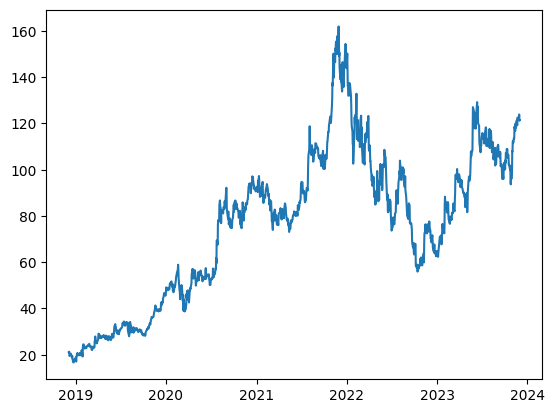

In [3]:
stock_df.head()

plt.plot('Date', 'AMD', data=stock_df)

In [4]:
from sklearn.preprocessing import MinMaxScaler
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
tf.random.set_seed(1)
amazon_series = np.asarray(stock_df['AMZN'])
scaler = MinMaxScaler()
amazon_series = amazon_series.reshape(-1,1)
scaler.fit(amazon_series)
amzn = scaler.transform(amazon_series)
print(amzn)

[[0.13589395]
 [0.14879055]
 [0.11944543]
 ...
 [0.66281598]
 [0.66088923]
 [0.66876374]]


In [5]:
def calculate_growth_rates(dataframe):
    num_indicators = len(dataframe.columns)
    max_value=0
    for i in range(1,num_indicators):
        dataframe[dataframe.columns[i]] = (dataframe[dataframe.columns[i]]-dataframe[dataframe.columns[i]].shift(1))/dataframe[dataframe.columns[i]].shift(1)
    dataframe = dataframe.iloc[1:]
    dataframe = dataframe.fillna(0)
    return dataframe


dataframe = calculate_growth_rates(stock_df)
dataframe.set_index(dataframe['Date'], inplace=True)
dataframe.drop(columns=dataframe.columns[0], axis=1, inplace=True)
dataframe.head()

,AAPL,MSFT,INTC,CSCO,META,QCOM,AMZN,TSLA,AMD,NFLX
Date,,,,,,,,,,
2018-12-06,-0.011149,0.006174,0.012984,0.021964,0.012325,-0.010740,0.018455,0.009341,0.008523,0.027422
2018-12-07,-0.035657,-0.040022,-0.044036,-0.040298,-0.015828,-0.019611,-0.041231,-0.014035,-0.086385,-0.062712
2018-12-10,0.006588,0.026426,0.020978,0.009044,0.032237,0.022325,0.007305,0.020072,0.027235,0.017198
2018-12-11,-0.005719,0.009295,0.003601,0.004908,0.001621,0.001922,0.001347,0.004412,-0.000500,-0.016240
2018-12-12,0.002787,0.004512,0.009498,0.007008,0.017033,0.006452,0.012354,-0.000438,0.025025,0.036032


In [6]:
dict_stocks = {"AAPL":0, "MSFT":1, "INTC":2, "CSCO":3, "META":4, "QCOM":5, "AMZN":6, "TSLA":7, "AMD":8, "NFLX":9}

In [7]:
def preprocess_FNN(data, look_back, stock):
    column_stock = dict_stocks[stock]
    data = np.array(data)[:, column_stock]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test

In [8]:
# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
#parameters to try: [2, [1,2,3,6,8,10,12], [3,4,5,6], [1], [500], [20], [future_steps]]
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)
    return model

def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

def forecast_FNN(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1])
    return forecasted_values

def FNN(data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, stock):
    X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back, stock)
    X_train, y_train = reshape_arrays(X_train, y_train)

    model_FNN = create_NN(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_FNN = train_model(model_FNN, X_train, y_train, epochs, batch_size)

    input_seq_for_test_FNN = np.reshape(input_seq_for_test_FNN, (1, len(input_seq_for_test_FNN)))
    forecasted_values_FNN = forecast_FNN(model_FNN, input_sequence=input_seq_for_test_FNN, future_steps=future_steps)

    return model_FNN, forecasted_values_FNN

In [9]:
# dataframe, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, stock name
FNN_model, values = FNN(dataframe, 2, 16, 1, 15, 50, 3, "INTC")

def calculate_performance(y_true, y_pred):
    print(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return mse

test_data = dataframe['2023-11-27': '2023-12-01']
y_true = test_data.iloc[:3].NFLX
mse = calculate_performance(y_true, values)
print(mse)

1/1 [==============================] - 0s 21ms/step
Date
2023-11-27   -0.000813
2023-11-28   -0.000355
2023-11-29   -0.003779
Name: NFLX, dtype: float64 [0.0021313091, -0.0021827498, 0.00017870308]
9.224319537040487e-06


## LSTM Code

In [10]:
def create_LSTM(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(1, input_nodes)))
    model.add(Dense(output_nodes))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [11]:
def preprocess_LSTM(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    print(X_train)
    return X_train, y_train, input_seq_for_test

def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)
    print(2)
    return model

def reshape_arrays(X_train, look_back):
    X_train = np.reshape(X_train, (len(X_train), 1, look_back))
    return X_train

def forecast_LSTM(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0][0] = np.append(forecasted_value, input_sequence[0][0][:-1])
    return forecasted_values

def Long_Short_Term_Memory(data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps):
    X_train, y_train, input_seq_for_test_LSTM = preprocess_LSTM(data, look_back)
    X_train = np.reshape(X_train, (len(X_train), 1, look_back))
    y_train = np.array(y_train)

    model_LSTM = create_LSTM(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_LSTM = train_model(model_LSTM, X_train, y_train, epochs, batch_size)
    print(1)

    input_seq_for_test_LSTM = np.reshape(input_seq_for_test_LSTM, (1, 1, len(input_seq_for_test_LSTM)))
    forecasted_values_LSTM = forecast_LSTM(model_LSTM, input_sequence=input_seq_for_test_LSTM, future_steps=future_steps)

    return model_LSTM, forecasted_values_LSTM

In [12]:
#parameters_LSTM = [[1,2,3,4,5,6,7,8,9,10,11,12,13], [3,4,5,6], [1], [300], [20], [future_steps]]

model_LSTM, forecasted_values_LSTM = Long_Short_Term_Memory(dataframe, 6, 6, 1, 25, 50, 3)

[[0.010940272028385538, 0.002787167170728808, -0.005719339622641503, 0.0065879280669475055, -0.035657051282051225, -0.011149470824608064], [-0.031997660134542256, 0.010940272028385538, 0.002787167170728808, -0.005719339622641503, 0.0065879280669475055, -0.035657051282051225], [-0.009306260575296061, -0.031997660134542256, 0.010940272028385538, 0.002787167170728808, -0.005719339622641503, 0.0065879280669475055], [0.01299255825301937, -0.009306260575296061, -0.031997660134542256, 0.010940272028385538, 0.002787167170728808, -0.005719339622641503], [-0.031191666164870277, 0.01299255825301937, -0.009306260575296061, -0.031997660134542256, 0.010940272028385538, 0.002787167170728808], [-0.025234632357511184, -0.031191666164870277, 0.01299255825301937, -0.009306260575296061, -0.031997660134542256, 0.010940272028385538], [-0.03889561946056253, -0.025234632357511184, -0.031191666164870277, 0.01299255825301937, -0.009306260575296061, -0.031997660134542256], [-0.02587407947986451, -0.0388956194605

In [28]:
forecasted_values_LSTM

def calculate_performance(y_true, y_pred):
    print(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return mse

test_data = dataframe['2023-11-27': '2023-12-01']
y_true = test_data.iloc[:3].NFLX
mse = calculate_performance(y_true, forecasted_values_LSTM)
print(mse)

Date
2023-11-27   -0.000813
2023-11-28   -0.000355
2023-11-29   -0.003779
Name: NFLX, dtype: float64 [-0.00012129736, 0.0006487553, -2.1969972e-05]
5.199646135828695e-06


In [14]:
import datetime
from statsmodels.tsa.arima.model import ARIMA

In [15]:
# load dataset
def parser(x):
  return datetime.datetime.strptime(x, '%Y/%m/%d')

dataframe.head()

,AAPL,MSFT,INTC,CSCO,META,QCOM,AMZN,TSLA,AMD,NFLX
Date,,,,,,,,,,
2018-12-06,-0.011149,0.006174,0.012984,0.021964,0.012325,-0.010740,0.018455,0.009341,0.008523,0.027422
2018-12-07,-0.035657,-0.040022,-0.044036,-0.040298,-0.015828,-0.019611,-0.041231,-0.014035,-0.086385,-0.062712
2018-12-10,0.006588,0.026426,0.020978,0.009044,0.032237,0.022325,0.007305,0.020072,0.027235,0.017198
2018-12-11,-0.005719,0.009295,0.003601,0.004908,0.001621,0.001922,0.001347,0.004412,-0.000500,-0.016240
2018-12-12,0.002787,0.004512,0.009498,0.007008,0.017033,0.006452,0.012354,-0.000438,0.025025,0.036032


In [89]:
dataframe_arima = dataframe.copy()

dataframe_arima.index = dataframe_arima.index.to_period('D')

dataframe_arima.head()
x_arima = dataframe_arima.loc['2018-12-06':'2023-11-22']['NFLX']
x_arima.head()
x_test = dataframe_arima.loc['2023-11-23':'2023-12-01']['NFLX']

In [90]:
model_arima = ARIMA(x_test.values, order=(1,0,1))
model_fit = model_arima.fit()

output = model_fit.forecast()
print(output)

predictions = []
for t in range(len(x_test)):
  model = ARIMA(x_arima.values, order=(3,0,1))
  model_fit = model.fit()
  output=model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  x_arima_list = x_arima.tolist()
  x_arima_list.extend(predictions)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[-0.01623969]


In [91]:
print(x_arima_list)
len(x_arima_list)
x_arima_results = pd.DataFrame(x_arima_list)
date_range = pd.date_range(start='2018-12-06', end='2023-12-01', freq='D')
x_arima_results.set_index(dataframe_arima.index, inplace=True)
x_arima_results.tail()
x_arima_results.rename(columns={x_arima_results.columns[0]: "Predictions" }, inplace = True)
#merge x_train and x_test together, create a new column, add to x_arima_results
x_complete = x_arima.tolist() + x_test.tolist()
x_arima_results['Real Values'] = x_complete
x_arima_results.tail()

[0.027421639487160903, -0.06271210407239822, 0.01719846119031456, -0.016240266963292532, 0.03603196140509574, 0.004147264260768286, -0.03325845953191801, -0.015140158896716998, 0.030974124809741196, -0.01539086144533851, -0.023203508640401837, -0.05445544554455445, -0.05077316449531227, 0.08461604241491359, 0.007470335475223757, 0.0020151429186312146, 0.045220243673852085, 0.0, 0.013225734140327143, 0.0972345132743363, 0.059717041368417455, 0.015633918944631214, -0.0009679333062728395, 0.014689336167021021, 0.03982627980040642, -0.013774104683195527, 0.06517690875232772, -0.009164222873900294, 0.0051225134465978294, -0.03989354171975417, -0.04110881745797699, -0.009749046623200934, 0.014534612876176299, 0.03483637922062018, -0.00706996006507909, -0.020139426800929654, 0.03575554879902721, -0.0034051546997006543, 0.0010309278350516134, 0.03380903339708681, 0.012722718733989946, -0.010173969253253154, -0.021238536017490612, 0.008296829218763638, -0.0052938976321315855, 0.0411882104532438

,Predictions,Real Values
Date,,
2023-11-27,0.000549,-0.000813
2023-11-28,0.000549,-0.000355
2023-11-29,0.000549,-0.003779
2023-11-30,0.000549,-0.006748
2023-12-01,0.000549,-0.017364


In [92]:
from sklearn.metrics import mean_squared_error
mean_squared_error(x_test.values, predictions)

6.715080695810448e-05